In [1]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

In [2]:
with open('mmlu_router_logits_100.pkl', 'rb') as f:
    data = pickle.load(f)
print(f"Model: {data['model_name']}")
print(f"Samples processed: {data['num_samples']}")

Model: allenai/OLMoE-1B-7B-0924-Instruct
Samples processed: 100


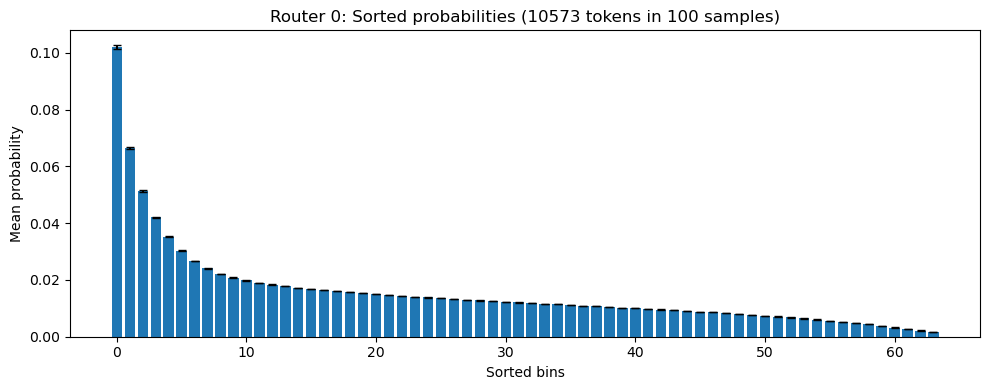

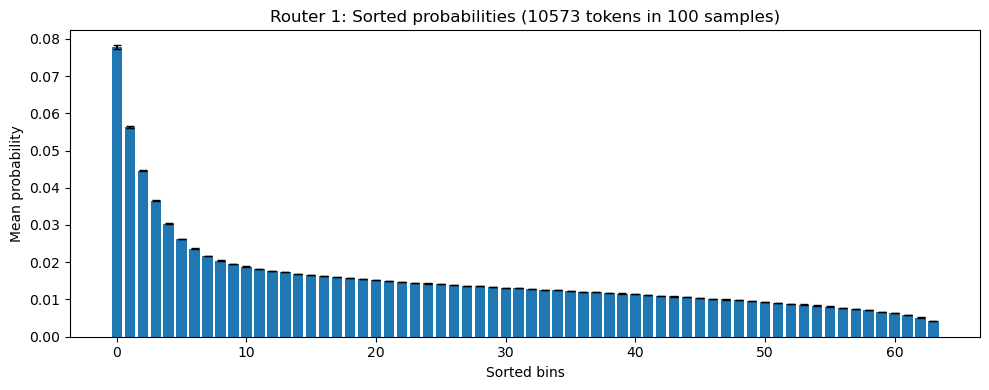

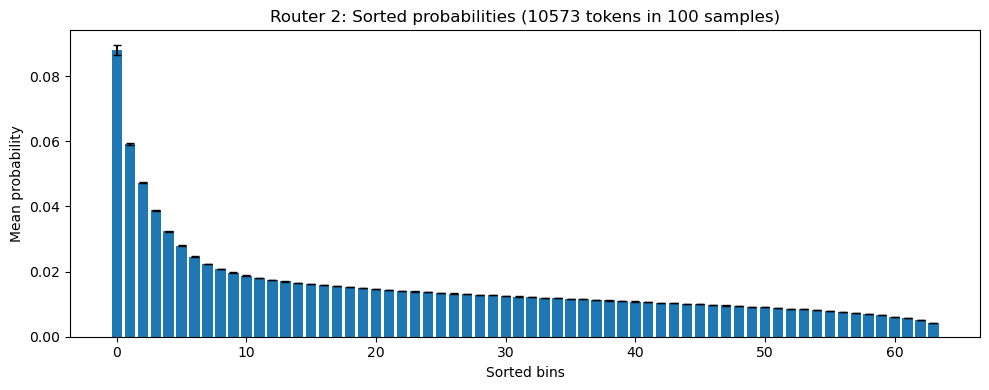

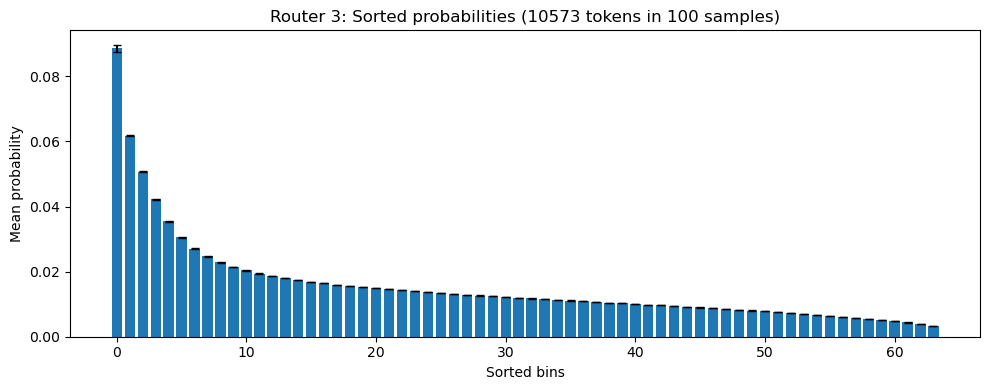

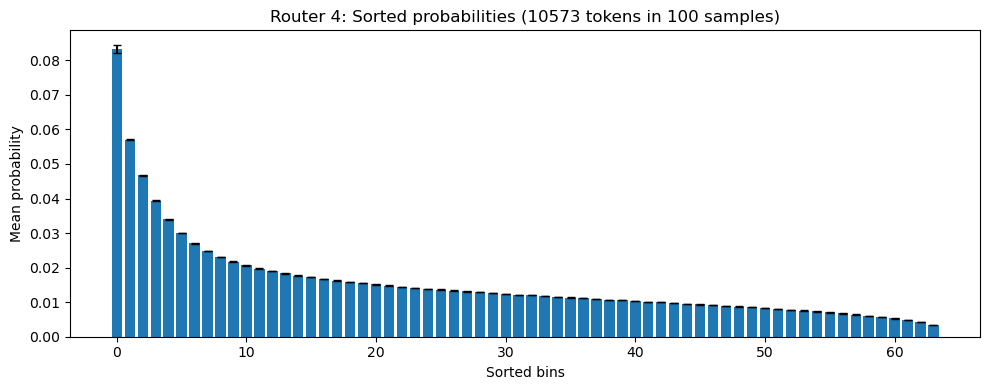

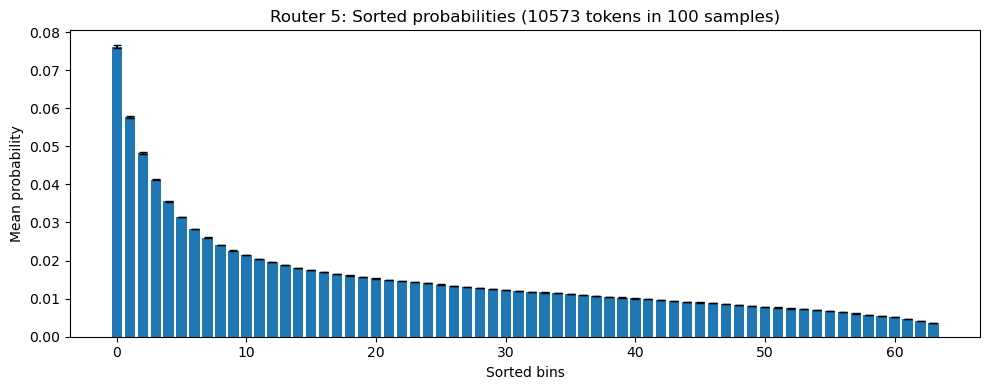

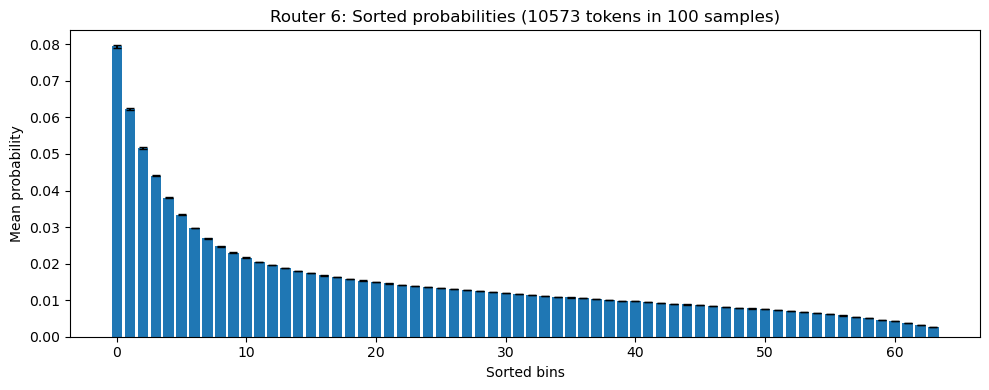

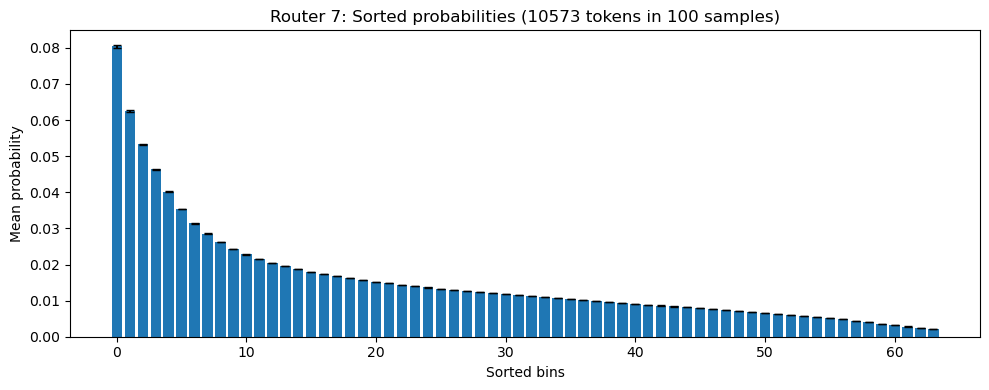

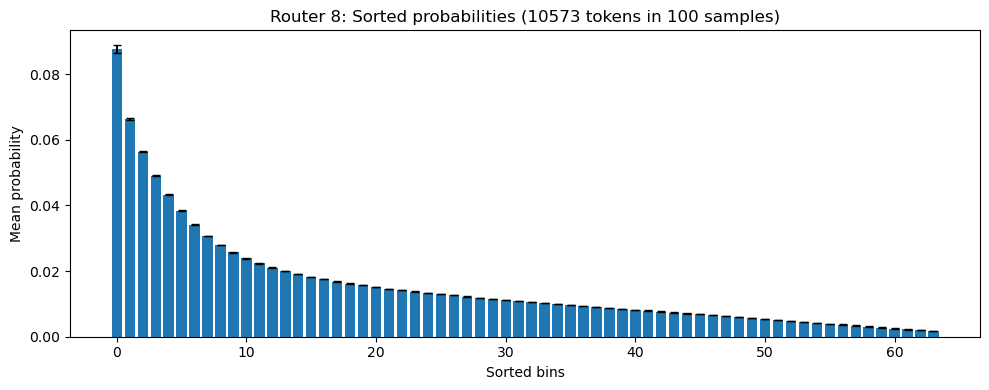

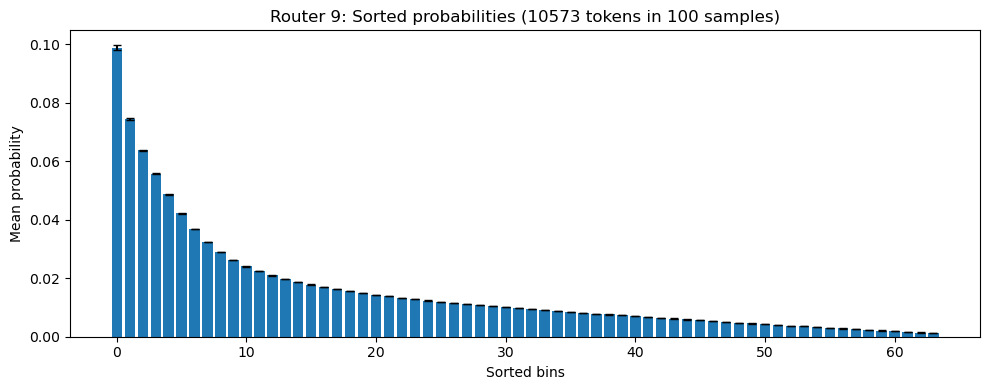

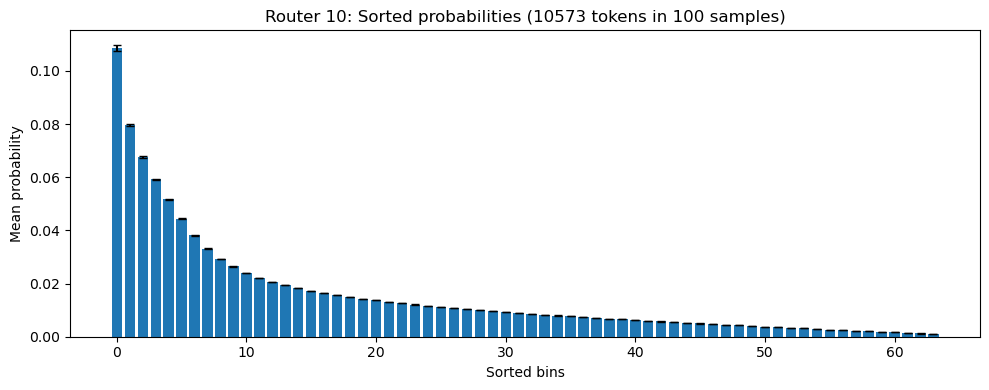

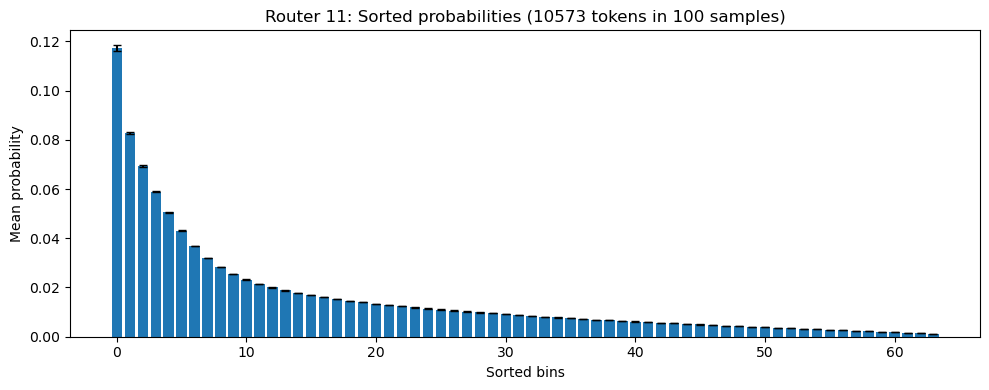

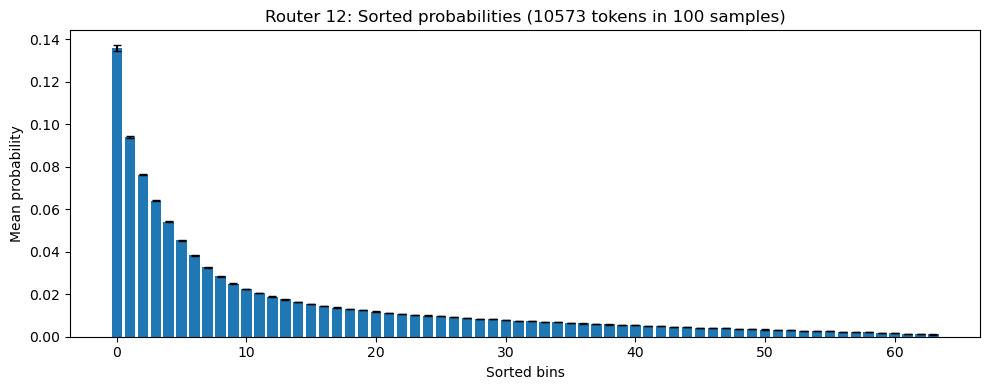

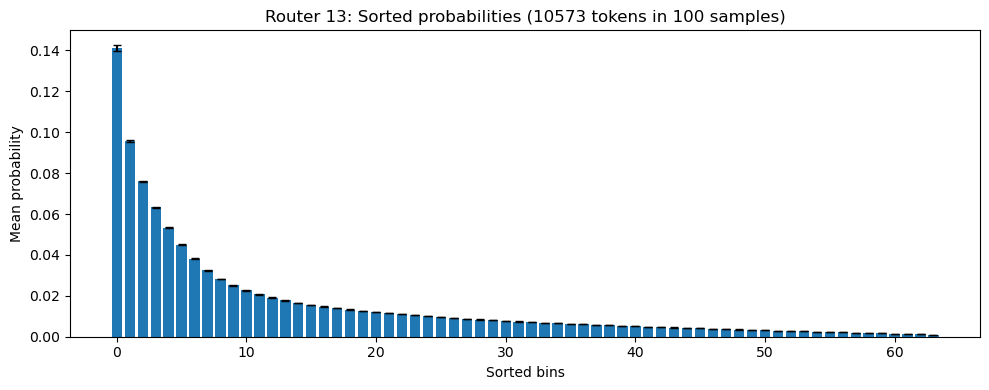

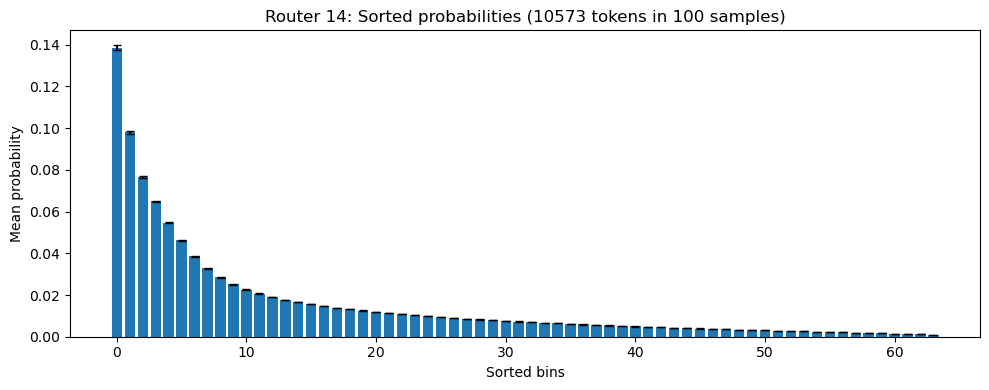

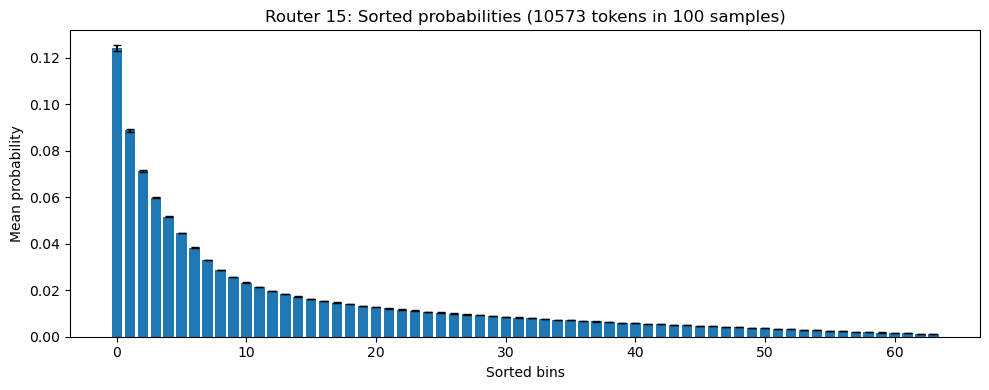

In [11]:
for layer in range(16):
    all_logits = []
    for sample in range(data['num_samples']):
        logits = data['router_logits'][sample]
        probs = torch.softmax(logits[f'model.layers.{layer}.mlp.gate'], dim=-1)
        probs, indices = torch.sort(probs, descending=True, dim=-1)
        all_logits.append(probs.float())
    all_logits = np.vstack(all_logits)
    
    means = all_logits.mean(axis=0)
    cis = 1.96 * sem(all_logits, axis=0) # Confidence intervals for each mean
    plt.figure(figsize=(10, 4))
    plt.bar(np.arange(64), means, yerr=cis, capsize=3)
    plt.xlabel("Sorted bins")
    plt.ylabel("Mean probability")
    plt.title(f"Router {layer}: Sorted probabilities ({all_logits.shape[0]} tokens in {data['num_samples']} samples)")
    
    plt.tight_layout()
    plt.savefig(f'out/router{layer}.png')

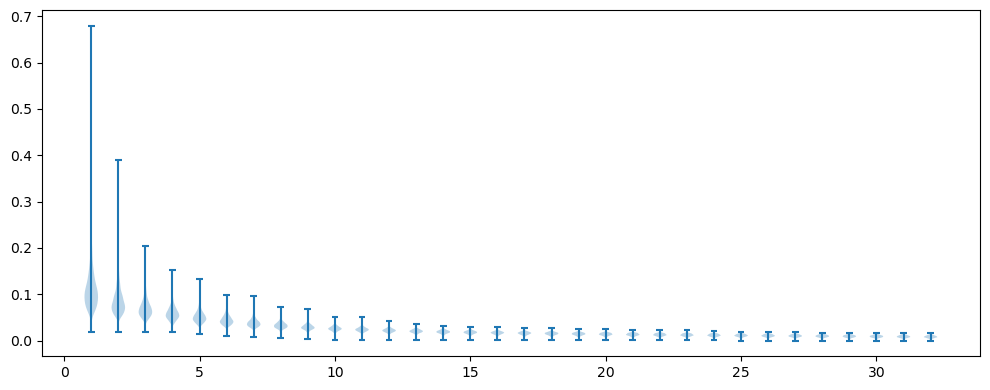

In [4]:
plt.figure(figsize=(10, 4))
plt.violinplot(all_logits[:,:32])
plt.tight_layout()
plt.show()

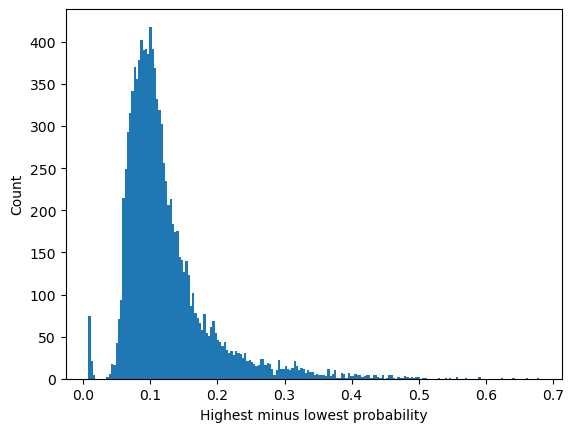

In [5]:
# Analysis of logit distributions (currently only looks at logits from the last router)
diffs = []
for i, logits in enumerate(all_logits):
    diffs.append(logits[0] - logits[-1])
plt.hist(diffs, bins=200)
plt.xlabel("Highest minus lowest probability")
plt.ylabel("Count")
plt.show()

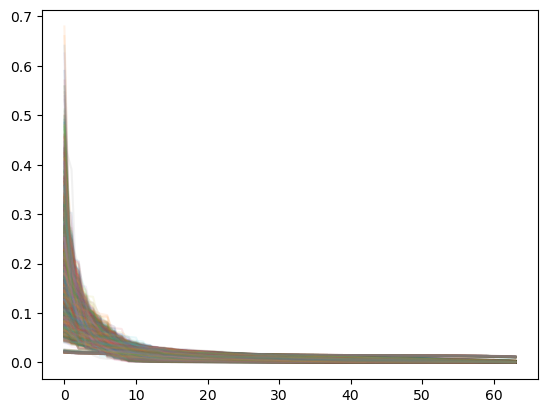

In [9]:
for logits in all_logits:
    plt.plot(logits, alpha=0.1)

100 10573


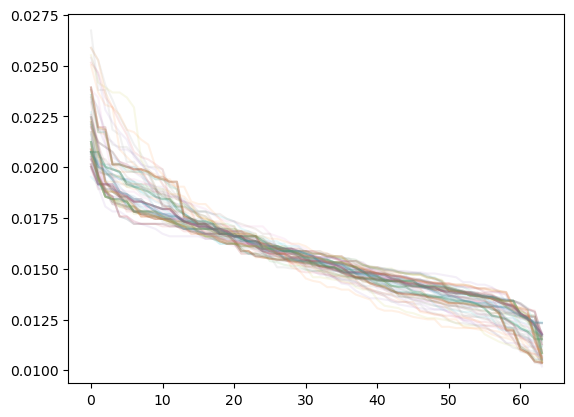

In [7]:
count = 0
low_idx = []
for i, logits in enumerate(all_logits):
    if logits[0] < 0.03:
        plt.plot(logits, alpha=0.1)
        count += 1
        low_idx.append(i)
print(count, all_logits.shape[0])